In [1]:
import math
import numpy as np

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Погрешности вычислений

**1.9.4\*.** Написать и полностью оттестировать программу, вычисляющую Евклидову норму вектора:

$$\left\|\vec{x}\right\| = \sqrt{\sum_{i = 1}^n x_i^2}$$

Постараться соблюсти следующие условия:

1. Результат должен вычисляться с высокой точностью, без переполнений.
2. Алгоритм должен обладать сложностью $O(n)$.
3. Алгоритм не должен быть привязан к стандарту IEEE 754.

In [2]:
def baseline(x):
    if isinstance(x, np.ndarray):
        return np.sqrt(np.sum(x ** 2))
    else:
        return math.sqrt(sum(x_i ** 2 for x_i in x))

### Валидация ошибки


Для выполнения 3 пункта, будем моделировать поведение погрешности методом Монте-Карло.

Будем оценивать погрешность вычисления нормы как:

$$\Delta\left\|\vec{x}\right\| = \mathbb{E}\left[\left|\left\|\vec{x}\right\| - \left\|\vec{x} + \Delta \vec{x}\right\|\right|\right],\quad \vec{x} \sim U^n\left(x_{\min}, x_{\max}\right),\quad \Delta\vec{x} \sim U^n\left(-\varepsilon, \varepsilon\right)$$

Для оценки математического ожидания воспользуемся средним по выборке из $N$ псевдослучайных величин.

In [3]:
def validate_error(L, N, n_s, x_min, x_max, eps, title = '', random_state=42):
    np.random.seed(random_state)
    def delta(L, n):
        x = np.random.uniform(x_min, x_max, n)
        delta_x = np.random.uniform(-eps, eps, n)
        return abs(L(x) - L(x + delta_x))
    
    deltas = [sum(delta(L, n) for _ in range(N)) / N for n in n_s]

    plt.figure(figsize=(12, 8))
    plt.plot(n_s, deltas)
    plt.title(title)
    plt.xlim(min(n_s), max(n_s))
    plt.ylim(0, max(deltas))
    plt.xlabel(r'n')
    plt.ylabel(r'$\Delta\left\|\cdot\right\|$')
    plt.grid()

CPU times: user 1min 47s, sys: 13.5 s, total: 2min
Wall time: 2min 1s


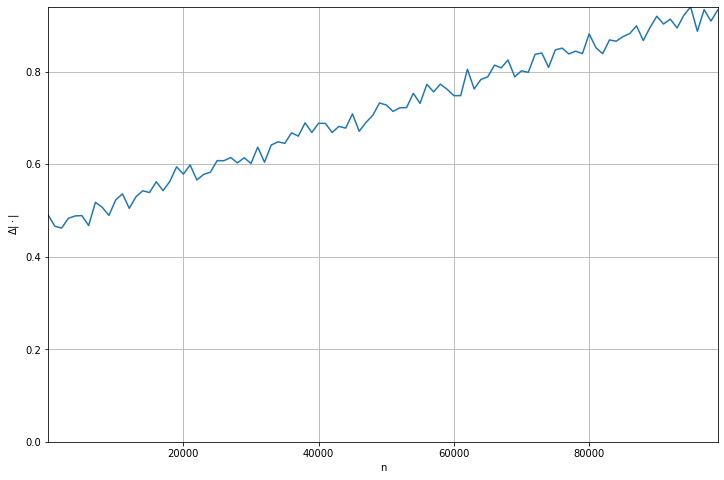

In [4]:
%%time
validate_error(baseline, 1000, range(1, 100_000, 1_000), -100, 100, 1)

Простейший способ избежать переполнения - нормализовать вектор делением на $\max_i{x_i}$:

In [5]:
def L(x):
    if isinstance(x, np.ndarray):
        x_max = np.abs(x).max()
        return np.sqrt(np.sum((x / x_max) ** 2)) * x_max
    else:
        x_max = max(abs(x_i) for x_i in x)
        return math.sqrt(sum((x_i / x_max) ** 2 for x_i in x)) * x_max

CPU times: user 2min 1s, sys: 38.7 ms, total: 2min 1s
Wall time: 2min 1s


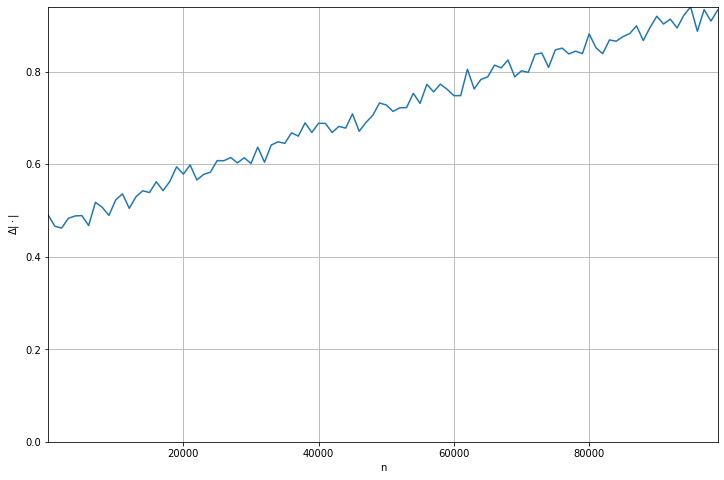

In [6]:
%%time
validate_error(L, 1000, range(1, 100_000, 1_000), -100, 100, 1, random_state=42)

Видно, что ошибка не меняется, однако переполнение случается при гораздо больших $x_i$:

### Валидация переполнения

Для оценки переполнения построим зависимость:

$$\alpha_{\lim}(n) = \arg\max_{\alpha \in  \mathbb{Z}}\left\{\left\|\vec{x}\right\| < \infty_{\mathrm{num}},\; x_i = 2^\alpha,\; i = 1 \ldots n\right\}$$

In [7]:
def validate_overflow(L, n_s):
    alphas = []
    for n in n_s:
        alpha_max = None
        for alpha in range(50, 200):
            try:
                if L(np.ones(n, dtype=np.float32) * np.float32(2 ** alpha)) < np.inf:
                    alpha_max = alpha
                else:
                    break
            except OverflowError:
                break
        alphas.append(alpha)
    plt.figure(figsize=(12, 8))
    plt.plot(n_s, alphas)

CPU times: user 41.7 ms, sys: 3.86 ms, total: 45.5 ms
Wall time: 44.4 ms


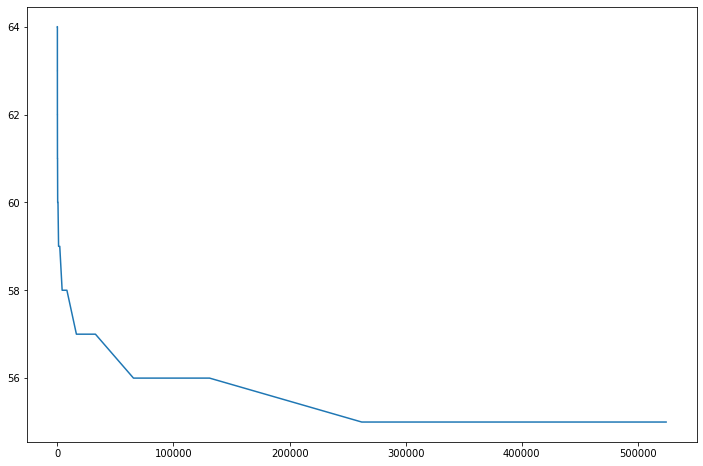

In [8]:
%%time
validate_overflow(baseline, [2 ** i for i in range(20)])

CPU times: user 251 ms, sys: 112 ms, total: 363 ms
Wall time: 359 ms


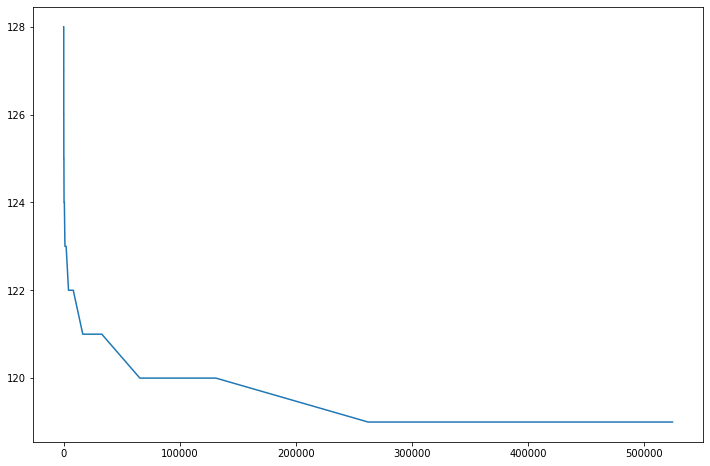

In [9]:
%%time
validate_overflow(L, [2 ** i for i in range(20)])

## Задачи для самостоятельного решения

**1.** Сравнить ошибки и переполнение для других способов нормализации: $s_1\left(\vec{x}\right) = \dfrac{\vec{x} - \min_i{\vec{x}}}{\max_i{\vec{x}} - \min_i{\vec{x}}}$ и $s_2\left(\vec{x}\right) = \dfrac{\vec{x} - \mu}{\sigma}$.

**2.** Изучить статью:

*S. Graillat et al.* Efficient Calculations of Faithfully Rounded $L_2$-norms of $n$-vectors // ACM Transactions on Mathematical Software. 2015 [DOI 10.1145/2699469](https://dx.doi.org/10.1145/2699469) [HAL-01511120](https://hal.archives-ouvertes.fr/hal-01511120)

Реализовать предложенные методы, сравнить ошибки и переполнение.